## MNIST machine learning exercise

In this exercise we will compare the performance of three different modeling approaches at predicting handwritten numbers. 

We use the MNIST data set;

![mnist data](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## Load libraries

In [1]:
# This set's the log level for tensoflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:

import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt

from sklearn import datasets

import tensorflow as tf
from tensorflow import keras

np.random.seed(1)
tf.random.set_seed(1)

## Load data and explore/get to know the data structure



Load the MNIST digits dataset. It's originally from UCI machine learning library, but included in SKLearn.

In [3]:
mnist = datasets.load_digits() # sklearn includes this data set .. https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

Notice that the dataset is stored in a dictionary

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

Note thjat there are 1797 images.

In [5]:
print(len(mnist.data))

1797


Images are 8x8 grid of values epresenting the gray level for each pixel (16 levels of grey -- from 0 (black) to 15 (white)). 

In [6]:
mnist.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

To analyze this, we simple turn this into a one dimensional array (so we will x1, x2, ... x63, x64). This has already been done for us, and is stored in the data key.

In [7]:
mnist.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [8]:
print(mnist.target[0])
print(mnist.target[1])
print(mnist.target[2])
print(mnist.target[3])
print(mnist.target[4])
print(mnist.target[5])
print(mnist.target[6])

0
1
2
3
4
5
6


We can use matplotlib to display a sample of these images from the data.

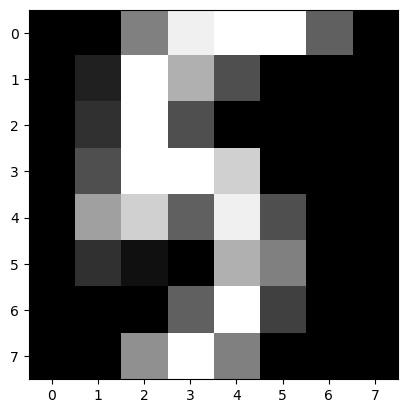

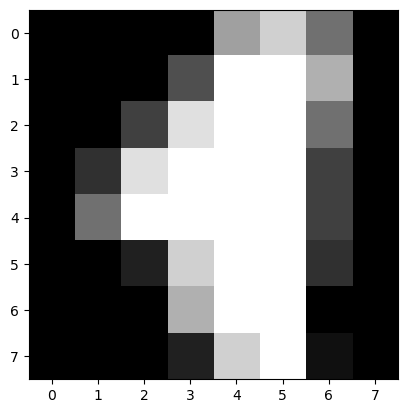

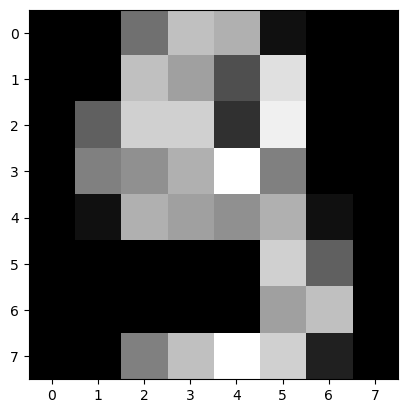

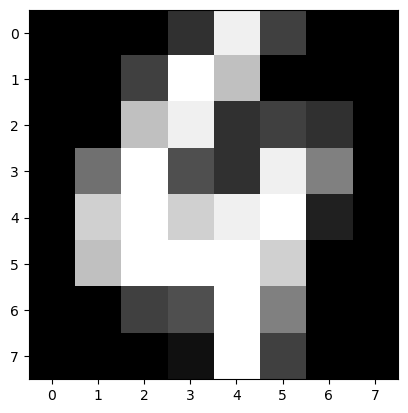

In [9]:
for i in np.random.choice(range(0,len(mnist.images)), 4): # choose 4 at random
  plt.imshow(mnist.images[i], cmap='gray')
  plt.show()

## Split data into training and test sets


In [10]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.2, random_state=1)

## RandomGridSearch

In [11]:
%%time

def build_clf(meta, hidden_layer_sizes, dropout):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    target_encoder_ = meta["target_encoder_"]
    
    model = tf.keras.models.Sequential()
    model.add(keras.layers.Input(shape=n_features_in_)),
    #for hidden_layer_size in hidden_layer_sizes:
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, 
            kernel_initializer= tf.keras.initializers.GlorotUniform(), 
            bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), 
            activation="relu"))
        model.add(keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    #though you could return a compiled model, it's not necessary, and would result in the loss of these
    # parameters in the tune process - as they would be 'hard coded'
    # model.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) 

    return model


CPU times: total: 0 ns
Wall time: 0 ns


### NOTES on the parameters and meta data 
* Meta is a dictionary of values set by the KerasClassifier. For example...
```
{
    'classes_': array([0,1,2,3,4,5,6,7,8,9]), 
    'target_type_': 'multiclass', 
    'y_dtype_': dtype('int64'), 
    'y_ndim_': 1, 
    'X_dtype_': dtype('float64'), 
    'X_shape_': (718,64), 
    'n_features_in_': 64, 
    'target_encoder_': ClassifierLabelEncoder(loss='sparse_categorical_crossentropy'), 
    'n_classes_': 10, 
    'n_outputs_': 1, 
    n_outputs_expected_': 1, 
    'feature_encoder_': FunctionTransformer()
}
```

* The passing of values from the sklearn grid/random search through to KerasClassifier and then to build_clf can be a bit confusing. The approach is well documented though, and you can find all the information about this here -> https://adriangb.com/scikeras/stable/advanced.html

For more information on dense layers and initializers, see the following:
* https://keras.io/api/layers/core_layers/dense/
* https://keras.io/api/layers/initializers/

In [12]:
%%time

# If you don't have the following installed, from command line '!pip install scikeras'
from scikeras.wrappers import KerasClassifier

keras_clf = KerasClassifier(
    model=build_clf,
    hidden_layer_sizes=64,
    dropout=0.5,
    optimizer=keras.optimizers.Adam,
    optimizer__learning_rate=0.0001
)
keras_clf.get_params()


CPU times: total: 15.6 ms
Wall time: 60.6 ms


{'model': <function __main__.build_clf(meta, hidden_layer_sizes, dropout)>,
 'build_fn': None,
 'warm_start': False,
 'random_state': None,
 'optimizer': keras.optimizers.optimizer_v2.adam.Adam,
 'loss': None,
 'metrics': None,
 'batch_size': None,
 'validation_batch_size': None,
 'verbose': 1,
 'callbacks': None,
 'validation_split': 0.0,
 'shuffle': True,
 'run_eagerly': False,
 'epochs': 1,
 'hidden_layer_sizes': 64,
 'dropout': 0.5,
 'optimizer__learning_rate': 0.0001,
 'class_weight': None}

In [13]:
%%time

params = {
    
    # the following are model parameters, and therefore must be defined as parameters in the KarasClassifier, and then in the build_clf function
    'model__hidden_layer_sizes': [(70,),(90, ), (100,), (100, 90)], # this will require KarasClassifier and build_clf to have hidden_layer_sizes parameter set
    'model__dropout': [0, 0.1], # this will require KarasClassifier and build_clf to have hidden_layer_sizes parameter set
    
    # the following are 'fit' parameters, the scikeras wrapper provides these parameters. These are passed to the 'model.fit' method for each fit of the model
    'batch_size':[20, 60, 100],
    'epochs':[10],
    'optimizer':['adam','sgd'],
    'loss':['sparse_categorical_crossentropy'],
    
    # this is added to the optimizer 
    'optimizer__learning_rate': [0.0001, 0.001, 0.01]

}
keras_clf.get_params()

CPU times: total: 0 ns
Wall time: 0 ns


{'model': <function __main__.build_clf(meta, hidden_layer_sizes, dropout)>,
 'build_fn': None,
 'warm_start': False,
 'random_state': None,
 'optimizer': keras.optimizers.optimizer_v2.adam.Adam,
 'loss': None,
 'metrics': None,
 'batch_size': None,
 'validation_batch_size': None,
 'verbose': 1,
 'callbacks': None,
 'validation_split': 0.0,
 'shuffle': True,
 'run_eagerly': False,
 'epochs': 1,
 'hidden_layer_sizes': 64,
 'dropout': 0.5,
 'optimizer__learning_rate': 0.0001,
 'class_weight': None}

In [14]:
%%time

from sklearn.model_selection import RandomizedSearchCV
#from tensorflow.keras.callbacks import EarlyStopping

rnd_search_cv = RandomizedSearchCV(
    estimator=keras_clf, 
    param_distributions=params, 
    scoring='accuracy',  # we could use any appropriate sklearn metric here (i.e. accuracy, f1_micro, f1_macro)
    n_iter=50, 
    cv=3)

# In rare cases, you may find your model training results in exceeding python's default recursion limit.
# If needed, you can increase this excersion limit by using the following code.
#import sys
#sys.setrecursionlimit(10000) # note: the default is 3000 (python 3.9)

_ = rnd_search_cv.fit(X_train, y_train,  verbose=1)

# You can create 'call back' functions. These are functions that will be called at the 
# end of each epoch. There are a number of builtin functions created for this purpose, 
# one of which is EarlyStopping -- that, based on the parameters you give, will stop
# the training process. This is useful when the algorithm is not making any significant
# gains through further training. 
#earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
#callback = [earlystop]
#_ = rnd_search_cv.fit(X_train, y_train, callbacks=callback, verbose=0)


Epoch 1/10
10/10 [==============================] - 1s 3ms/step - loss: 15.7791
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 13.8890
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 12.4377
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 11.3475
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 10.5153
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 9.8437
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 9.2678
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 8.7668
Epoch 9/10
10/10 [==============================] - 0s 3ms/step - loss: 8.3189
Epoch 10/10
5/5 [==============================] - 0s 3ms/step
Epoch 1/10
10/10 [==============================] - 1s 3ms/step - loss: 10.3266
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 9.5505
Epoch 3/10
10/10 [==============================] - 0s 2ms/ste

In [15]:
rnd_search_cv.best_params_

{'optimizer__learning_rate': 0.01,
 'optimizer': 'adam',
 'model__hidden_layer_sizes': (70,),
 'model__dropout': 0,
 'loss': 'sparse_categorical_crossentropy',
 'epochs': 10,
 'batch_size': 100}

In [16]:
best_model = rnd_search_cv.best_estimator_

In [17]:
%%time

print(f"best score {best_model.score(X_test, y_test)}")
print(f"min loss {min(best_model.history_['loss'])}")

4/4 [==============================] - 0s 3ms/step
best score 0.9694444444444444
min loss 0.02371547371149063
CPU times: total: 297 ms
Wall time: 277 ms


In [18]:
best_model.history_

defaultdict(list,
            {'loss': [3.2786741256713867,
              0.3874664604663849,
              0.17417611181735992,
              0.10418892651796341,
              0.07465196400880814,
              0.0634399801492691,
              0.04426172748208046,
              0.03425392508506775,
              0.032469019293785095,
              0.02371547371149063]})

4/4 [==============================] - 0s 4ms/step


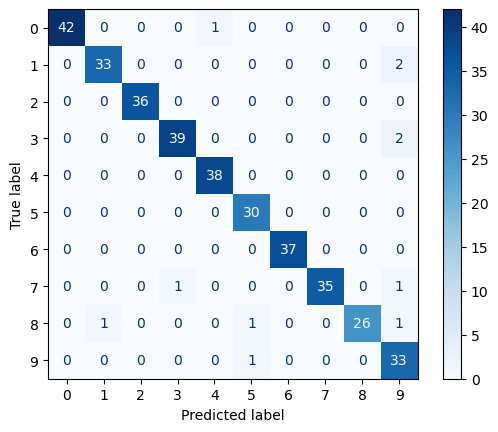

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, best_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, best_model.predict(X_test), digits=4))

4/4 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0     1.0000    0.9767    0.9882        43
           1     0.9706    0.9429    0.9565        35
           2     1.0000    1.0000    1.0000        36
           3     0.9750    0.9512    0.9630        41
           4     0.9744    1.0000    0.9870        38
           5     0.9375    1.0000    0.9677        30
           6     1.0000    1.0000    1.0000        37
           7     1.0000    0.9459    0.9722        37
           8     1.0000    0.8966    0.9455        29
           9     0.8462    0.9706    0.9041        34

    accuracy                         0.9694       360
   macro avg     0.9704    0.9684    0.9684       360
weighted avg     0.9718    0.9694    0.9698       360

